In [1]:
import tensorflow as tf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from utils import *

%load_ext autoreload
%autoreload 2
    
MODEL_PATH = "models/recognition/"

In [2]:
height = 28
width = 28
channels = 1
n_inputs = height * width

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, n_inputs) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, n_inputs) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
nb_samples_taken = 2000
X_train = X_train[:nb_samples_taken]
y_train = y_train[:nb_samples_taken]

In [5]:
tf.reset_default_graph()

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2

conv3_fmaps = 128
conv3_ksize = 3
conv3_stride = 2

pool3_fmaps = conv3_fmaps

n_fc1 = 128
n_outputs = 10

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv2")
conv3 = tf.layers.conv2d(conv2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv3")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 3 * 3])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    loss_ = tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy_train = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_test = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    accuracy_train_ = tf.summary.scalar('accuracy_train', accuracy_train)
    accuracy_test_ = tf.summary.scalar('accuracy_test', accuracy_test)

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [5]:
n_epochs = 10
batch_size = 100

now = datetime.now()
logdir = "tf_logs/" + now.strftime("3_conv_layers_%Y%m%d-%H%M%S") + "/"

with tf.Session() as sess:
    merged = tf.summary.merge([accuracy_train_,loss_])
    tf_tensorboard_writer = tf.summary.FileWriter('./'+logdir, sess.graph)    
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})       
        print(epoch, "Last batch accuracy:", accuracy_train.eval(feed_dict={X: X_batch, y: y_batch}), "Test accuracy:", accuracy_test.eval(feed_dict={X: X_test, y: y_test}))
        
        summary_str = sess.run(merged, feed_dict={X: X_batch, y: y_batch})
        test_summary_str = sess.run(accuracy_test_, feed_dict={X: X_test, y: y_test})
        tf_tensorboard_writer.add_summary(summary_str, epoch) 
        tf_tensorboard_writer.add_summary(test_summary_str, epoch) 
        save_path = saver.save(sess, MODEL_PATH + "model3conv")
        
tf_tensorboard_writer.close()


0 Last batch accuracy: 0.67 Test accuracy: 0.5866
1 Last batch accuracy: 0.77 Test accuracy: 0.7573
2 Last batch accuracy: 0.88 Test accuracy: 0.8325
3 Last batch accuracy: 0.88 Test accuracy: 0.8722
4 Last batch accuracy: 0.91 Test accuracy: 0.8758
5 Last batch accuracy: 0.92 Test accuracy: 0.9081
6 Last batch accuracy: 0.98 Test accuracy: 0.9014
7 Last batch accuracy: 0.97 Test accuracy: 0.9226
8 Last batch accuracy: 0.97 Test accuracy: 0.9126
9 Last batch accuracy: 0.97 Test accuracy: 0.9188


# Testing rotation and zoom

In [51]:
samples_to_show = 5
plt.figure(figsize=(8,50)) # not shown in the book
X_reshaped = tf.reshape(X_train, shape=[-1, height, width])
with tf.Session() as sess:
    X_reshaped = X_reshaped.eval()

<Figure size 576x3600 with 0 Axes>

### Original images

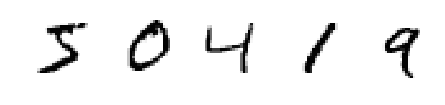

In [27]:
plt.figure(figsize=(15,50)) # not shown in the book
for iteration in range(samples_to_show):
    plt.subplot(samples_to_show, 10, iteration + 1)
    plot_image(X_reshaped[iteration])

### Rotation

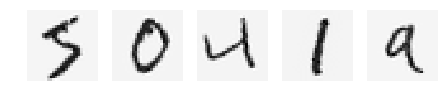

In [28]:
from scipy.ndimage import rotate
plt.figure(figsize=(15,50)) # not shown in the book
degrees = 10
for iteration in range(samples_to_show):
    plt.subplot(samples_to_show, 10, iteration + 1)
    plot_image(rotate(X_reshaped[iteration], 20, reshape=False))

### Zoom

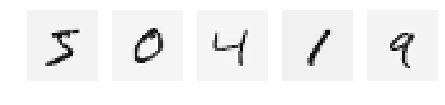

In [57]:
plt.figure(figsize=(15,50)) # not shown in the book
for iteration in range(samples_to_show):
    plt.subplot(samples_to_show, 10, iteration + 1)
    plot_image(clipped_zoom(X_reshaped[iteration], 0.7))

# Increasing dataset

In [58]:
X_train_zoom1 = X_reshaped.copy()
X_train_zoom2 = X_reshaped.copy()
X_train_rotate1 = X_reshaped.copy()
X_train_rotate2 = X_reshaped.copy()

for iteration in range(nb_samples_taken):
    X_train_zoom1[iteration] = clipped_zoom(X_train_zoom[iteration], 0.95)
    X_train_zoom2[iteration] = clipped_zoom(X_train_zoom[iteration], 1.05)

for iteration in range(nb_samples_taken):
    X_train_rotate1[iteration] = rotate(X_train_rotate1[iteration], 8, reshape=False)    
    X_train_rotate2[iteration] = rotate(X_train_rotate2[iteration], -8, reshape=False)

X_train_artificially_increased = np.concatenate((X_reshaped, X_train_zoom1, X_train_zoom2,X_train_rotate1,X_train_rotate2), axis=0)

In [59]:
X_train_artificially_increased = X_train_artificially_increased.astype(np.float32).reshape(-1, n_inputs)
X_train_artificially_increased.shape

(300000, 784)

In [60]:
y_train_artificially_increased = np.concatenate((y_train,y_train,y_train,y_train,y_train), axis=0)
y_train_artificially_increased.shape

(300000,)

# Training model with dataset artificially_increased

In [16]:
n_epochs = 10
batch_size = 100

now = datetime.now()
logdir = "tf_logs/" + now.strftime("3_conv_DatasetIncreasedArt__%Y%m%d-%H%M%S") + "/"

with tf.Session() as sess:
    merged = tf.summary.merge([accuracy_train_,loss_])
    tf_tensorboard_writer = tf.summary.FileWriter('./'+logdir, sess.graph)
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_artificially_increased, y_train_artificially_increased, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})       
        print(epoch, "Last batch accuracy:", accuracy_train.eval(feed_dict={X: X_batch, y: y_batch}), "Test accuracy:", accuracy_test.eval(feed_dict={X: X_test, y: y_test}))
        
        summary_str = sess.run(merged, feed_dict={X: X_batch, y: y_batch})
        test_summary_str = sess.run(accuracy_test_, feed_dict={X: X_test, y: y_test})
        tf_tensorboard_writer.add_summary(summary_str, epoch) 
        tf_tensorboard_writer.add_summary(test_summary_str, epoch) 
        save_path = saver.save(sess, MODEL_PATH + "with_dataset_artificially_increased/model3conv")
        
tf_tensorboard_writer.close()

0 Last batch accuracy: 0.83 Test accuracy: 0.8443
1 Last batch accuracy: 0.9 Test accuracy: 0.924
2 Last batch accuracy: 0.95 Test accuracy: 0.9351
3 Last batch accuracy: 0.97 Test accuracy: 0.9331
4 Last batch accuracy: 0.96 Test accuracy: 0.9448
5 Last batch accuracy: 0.99 Test accuracy: 0.9459
6 Last batch accuracy: 1.0 Test accuracy: 0.9441
7 Last batch accuracy: 1.0 Test accuracy: 0.9479
8 Last batch accuracy: 1.0 Test accuracy: 0.9525
9 Last batch accuracy: 1.0 Test accuracy: 0.9544


## Better network

In [61]:
tf.reset_default_graph()

conv1_fmaps = 6
conv1_ksize = 6
conv1_stride = 1

conv2_fmaps = 12
conv2_ksize = 5
conv2_stride = 2

pool1_fmaps = conv2_fmaps

conv3_fmaps = 24
conv3_ksize = 4
conv3_stride = 2

conv4_fmaps = 48
conv4_ksize = 4
conv4_stride = 2

pool2_fmaps = conv4_fmaps

n_fc1 = 200
n_outputs = 10

in_training_mode = tf.placeholder_with_default(False, shape=[], name='training')
fc1_dropout_rate = 0.5

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    X_BN = tf.layers.batch_normalization(X_reshaped, momentum=0.9, training=in_training_mode)
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_BN, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="SAME",
                         activation=None, name="conv1")
conv1_BN = tf.layers.batch_normalization(conv1, momentum=0.9, training=in_training_mode)
conv1_relu = tf.nn.relu(conv1_BN) 

conv2 = tf.layers.conv2d(conv1_relu, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="SAME",
                         activation=None, name="conv2")
conv2_BN = tf.layers.batch_normalization(conv2, momentum=0.9, training=in_training_mode)
conv2_relu = tf.nn.relu(conv2_BN) 

pool1 = tf.nn.max_pool(conv2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID", name="conv3")
    

conv3 = tf.layers.conv2d(pool1, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="SAME",
                         activation=None, name="conv3")
conv3_BN = tf.layers.batch_normalization(conv3, momentum=0.9, training=in_training_mode)
conv3_relu = tf.nn.relu(conv3_BN) 

conv4 = tf.layers.conv2d(conv3_relu, filters=conv4_fmaps, kernel_size=conv4_ksize,
                         strides=conv4_stride, padding="SAME",
                         activation=None, name="conv4")
conv4_BN = tf.layers.batch_normalization(conv4, momentum=0.9, training=in_training_mode)
conv4_relu = tf.nn.relu(conv4_BN) 

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv4_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_flat = tf.reshape(pool2, shape=[-1, pool2_fmaps * int(pool2.shape[1]) * int(pool2.shape[1])])
    

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool2_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=in_training_mode)   


with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    loss_ = tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy_train = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_test = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    accuracy_train_ = tf.summary.scalar('accuracy_train', accuracy_train)
    accuracy_test_ = tf.summary.scalar('accuracy_test', accuracy_test)

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [ ]:
n_epochs = 20
batch_size = 100

now = datetime.now()
logdir = "tf_logs/" + now.strftime("4conv_DatasetIncreasedArt__%Y%m%d-%H%M%S") + "/"

with tf.Session() as sess:
    merged = tf.summary.merge([accuracy_train_,loss_])
    tf_tensorboard_writer = tf.summary.FileWriter('./'+logdir, sess.graph)    
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_artificially_increased, y_train_artificially_increased, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, in_training_mode: True})       
        print(epoch, "Last batch accuracy:", accuracy_train.eval(feed_dict={X: X_batch, y: y_batch}), "Test accuracy:", accuracy_test.eval(feed_dict={X: X_test, y: y_test}))
        
        summary_str = sess.run(merged, feed_dict={X: X_batch, y: y_batch})
        test_summary_str = sess.run(accuracy_test_, feed_dict={X: X_test, y: y_test})
        tf_tensorboard_writer.add_summary(summary_str, epoch) 
        tf_tensorboard_writer.add_summary(test_summary_str, epoch) 
        save_path = saver.save(sess, MODEL_PATH + "with_dataset_artificially_increased/model4conv")
        
tf_tensorboard_writer.close()
